In [1]:
%pip install scikit-learn

You should consider upgrading via the '/Users/kashaina/Documents/Classes/CSC4260_DS/myenv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [19]:
import numpy as np
import pandas as pd
import pickle
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA


In [2]:
# Load datasets
train_dir = "train.csv"
test_dir = "train.csv"

# Read the data
train_data = pd.read_csv(train_dir)
test_data = pd.read_csv(train_dir)

In [3]:
# Global dictionaries for storing encoders
label_encoders = {}

# Path to save/load the scaler
# In case test data has different distribution, we need to scale it using the same scaler as train data
# Exp: Train data has Age from 0-100, but test data has Age from 0-80. We need to scale both to 0-1 range.
scaler_path = "scaler.pkl"
standard_scaler_path = "standard_scaler.pkl"  # Path to save/load standard scaler

In [4]:
# Global dictionaries for storing encoders and scaler
label_encoders = {}
scaler_path = "scaler.pkl"  # Path to save/load scaler

def preprocess_dataset(df, is_train=True):
    """
    Preprocess a single dataset (train or test) with specific transformations.
    
    Parameters:
        df (DataFrame): The dataset to preprocess.
        is_train (bool): True if processing training data, False for test data.
    
    Returns:
        Processed DataFrame.
    """
    # Drop case_id and patientid
    df.drop(columns=[col for col in ['case_id', 'patientid'] if col in df.columns], inplace=True)

    # Encode 'Stay' column per 10 days
    stay_mapping = {
        '0-10': 1, '11-20': 2, '21-30': 3, '31-40': 4, '41-50': 5,
        '51-60': 6, '61-70': 7, '71-80': 8, '81-90': 9, '91-100': 10,
        '100 Days': 10, 'More than 100 Days': 11
    }
    if 'Stay' in df.columns:
        df['Stay'] = df['Stay'].map(stay_mapping)

    # Handle 'Stay' separately for training data
  #  target_column = 'Stay'
   # if not is_train:
    #    df.drop(columns=[target_column], errors='ignore', inplace=True)  # Ensure Stay isn't in test data

    # Convert categorical variables using the specified mappings
    if 'Hospital_type_code' in df.columns:
        df['Hospital_type_code'] = df['Hospital_type_code'].map(lambda x: ord(x.lower()) - ord('a') + 1)


    
    if 'Ward_Type' in df.columns:
        df['Ward_Type'] = df['Ward_Type'].map(lambda x: ord(x) - ord('P') + 1)
    
    # Map Admission Type & Severity of Illness based on their order
    admission_mapping = {'Trauma': 1, 'Urgent': 2, 'Emergency': 3}
    severity_mapping = {'Minor': 1, 'Moderate': 2, 'Extreme': 3}

    if 'Type of Admission' in df.columns:
        df['Type of Admission'] = df['Type of Admission'].map(admission_mapping)
    
    if 'Severity of Illness' in df.columns:
        df['Severity of Illness'] = df['Severity of Illness'].map(severity_mapping)

    # Label Encode Age by decade
    if 'Age' in df.columns:
        if is_train:
            le = LabelEncoder()
            df['Age'] = le.fit_transform(df['Age'])
            label_encoders['Age'] = le  # Save encoder for test data
        else:
            if 'Age' in label_encoders:
                df['Age'] = label_encoders['Age'].transform(df['Age'])  # Use saved mappings
            else:
                raise ValueError("Missing encoder for Age in test data!")
            
    df = pd.get_dummies(df, columns=['Department', 'Hospital_region_code', 'Ward_Facility_Code'], drop_first=True)

    # Handle missing values
    df.fillna(df.median(numeric_only=True), inplace=True)  # Fill numerical with median
    df.fillna(df.mode().iloc[0], inplace=True)  # Fill categorical with mode

    # Normalize selected numerical columns
    scale_cols = ['Available Extra Rooms in Hospital', 'Bed Grade', 'Visitors with Patient', 'Type of Admission', 
                  'Severity of Illness', 'Age']
    scale_cols = [col for col in scale_cols if col in df.columns]  # Ensure they exist in df

    if is_train:
        scaler = MinMaxScaler()
        df[scale_cols] = scaler.fit_transform(df[scale_cols])  # Fit & transform train
        with open(scaler_path, "wb") as f:
            pickle.dump(scaler, f)  # Save scaler for test
    else:
        with open(scaler_path, "rb") as f:
            scaler = pickle.load(f)  # Load trained scaler
        df[scale_cols] = scaler.transform(df[scale_cols])  # Transform test data

    # Standardize Admission_Deposit
    if 'Admission_Deposit' in df.columns:
        if is_train:
            standard_scaler = StandardScaler()
            df['Admission_Deposit'] = standard_scaler.fit_transform(df[['Admission_Deposit']])
            with open(standard_scaler_path, "wb") as f:
                pickle.dump(standard_scaler, f)  # Save standard scaler
        else:
            with open(standard_scaler_path, "rb") as f:
                standard_scaler = pickle.load(f)  # Load trained standard scaler
            df['Admission_Deposit'] = standard_scaler.transform(df[['Admission_Deposit']])

    return df


In [5]:
# Process datasets
train_cleaned = preprocess_dataset(train_data, is_train=True)
test_cleaned = preprocess_dataset(test_data, is_train=False)

# Save cleaned datasets
train_cleaned_path = "train_cleaned.csv"
test_cleaned_path = "test_cleaned.csv"

train_cleaned.to_csv(train_cleaned_path, index=False)
test_cleaned.to_csv(test_cleaned_path, index=False)

print(f"Processed train data saved at: {train_cleaned_path}")
print(f"Processed test data saved at: {test_cleaned_path}")

Processed train data saved at: train_cleaned.csv
Processed test data saved at: test_cleaned.csv


In [6]:
print(train_cleaned.head())

   Hospital_code  Hospital_type_code  City_Code_Hospital  \
0              8                   3                   3   
1              2                   3                   5   
2             10                   5                   1   
3             26                   2                   2   
4             26                   2                   2   

   Hospital_region_code  Available Extra Rooms in Hospital  Department  \
0                     3                           0.125000           3   
1                     3                           0.083333           3   
2                     1                           0.083333           1   
3                     2                           0.083333           3   
4                     2                           0.083333           3   

   Ward_Type  Ward_Facility_Code  Bed Grade  City_Code_Patient  \
0          3                   6   0.333333                7.0   
1          4                   6   0.333333                7.0

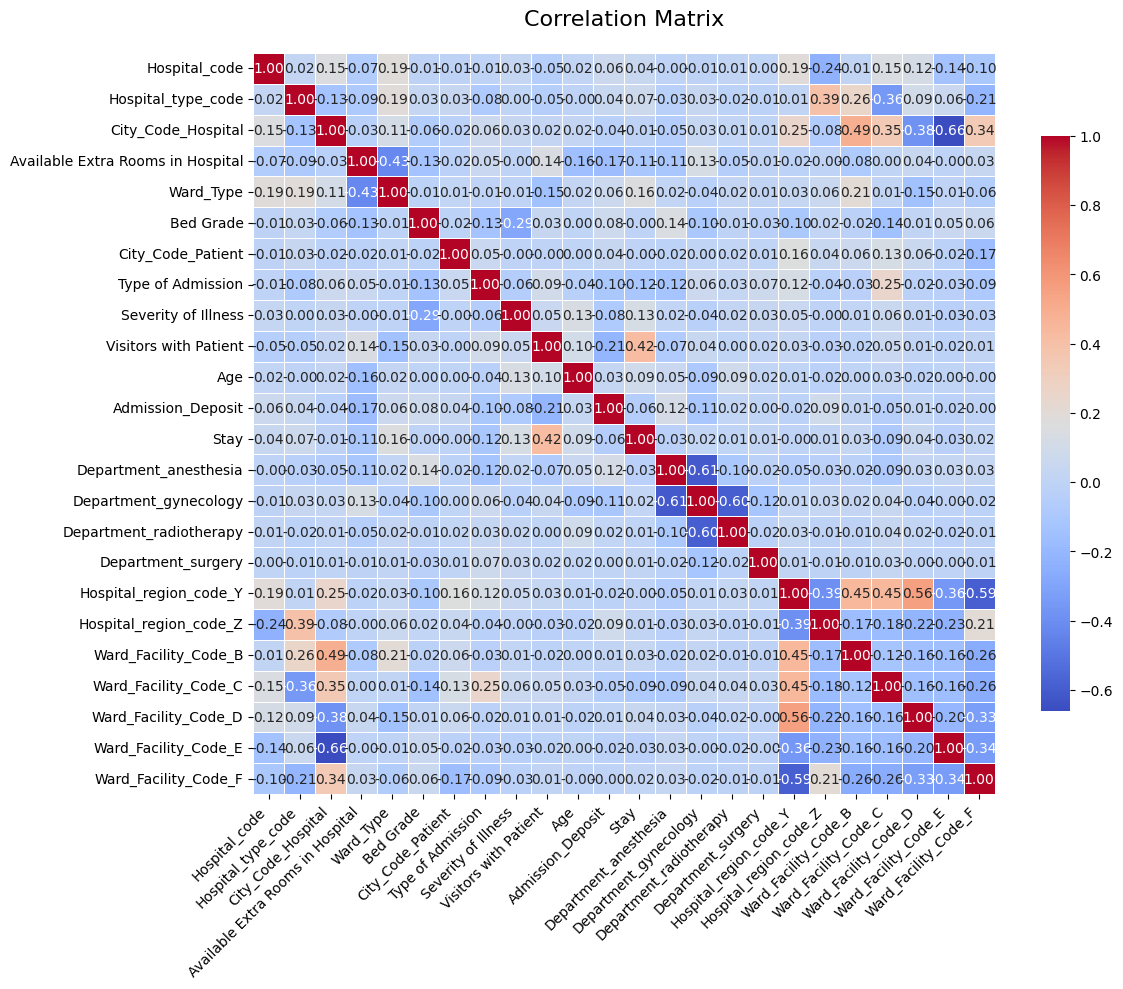

In [6]:
correlation_matrix = test_cleaned.corr(method='spearman')



    # Set up the matplotlib figure
plt.figure(figsize=(12, 10))  # Adjust size as needed

    # Draw the heatmap with enhancements
sns.heatmap(
        correlation_matrix,
        annot=True,               # Display correlation coefficients
        fmt=".2f",                # Limit to 2 decimal places
        cmap='coolwarm',          # Color map for better contrast
        linewidths=0.5,           # Add lines between squares
        square=True,              # Make cells square-shaped
        cbar_kws={"shrink": 0.75} # Adjust color bar size
    )

    # Improve readability
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for clarity
plt.yticks(rotation=0)               # Keep y-axis labels horizontal
plt.title("Correlation Matrix", fontsize=16, pad=20)

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


Nothing seems to have a strong linear correlation with stay, but that doesnt mean there isnt a correlation, might be nonlinear 

We are going to try a benchmark model with and without these features:hospital code, department,  hospital type code, city code hospital, ward type, city code patient, hospital region code, and ward facility code 

In [8]:
features_to_drop = ['Hospital_code', 'Hospital_type_code', 'City_Code_Hospital', 
                     'Ward_Type', 'City_Code_Patient', 'Hospital_region_code_Y', 'Hospital_region_code_Z' ,
                     'Ward_Facility_Code_B',  'Ward_Facility_Code_C',  'Ward_Facility_Code_D',  'Ward_Facility_Code_E',  'Ward_Facility_Code_F']

In [9]:
X = train_cleaned.drop(columns=['Stay'])
y = train_cleaned['Stay']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_reduced = scaler.fit_transform(X.drop(columns=features_to_drop))

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train_reduced, X_test_reduced, _, _ = train_test_split(X_scaled_reduced, y, test_size=0.2, random_state=42)

In [53]:
log_reg = LogisticRegression(max_iter=200, solver='saga', n_jobs=1)
log_reg.fit(X_train_reduced, y_train)
y_pred_log_reg = log_reg.predict(X_test_reduced)

In [54]:
print("Logistic Regression (All Features)")
print("Accuracy:", accuracy_score(y_test, y_pred_log_reg))

print(classification_report(y_test, y_pred_log_reg))

Logistic Regression (All Features)
Accuracy: 0.3637576937570657
              precision    recall  f1-score   support

           1       0.51      0.03      0.05      4689
           2       0.35      0.41      0.38     15561
           3       0.39      0.64      0.49     17603
           4       0.29      0.22      0.25     10981
           5       0.00      0.00      0.00      2357
           6       0.35      0.37      0.36      7128
           7       0.00      0.00      0.00       554
           8       0.00      0.00      0.00      2031
           9       0.00      0.00      0.00       941
          10       0.00      0.00      0.00       552
          11       0.48      0.29      0.36      1291

    accuracy                           0.36     63688
   macro avg       0.22      0.18      0.17     63688
weighted avg       0.33      0.36      0.32     63688



c:\Users\jayjo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jayjo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jayjo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [55]:
# Dummy Classifier (Most Frequent Class)
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train_reduced, y_train)
y_pred_dummy = dummy_clf.predict(X_test_reduced)

In [56]:
print("\nDummy Classifier (Most Frequent Class)")
print("Accuracy:", accuracy_score(y_test, y_pred_dummy))
print(classification_report(y_test, y_pred_dummy))


Dummy Classifier (Most Frequent Class)
Accuracy: 0.27639429719884434
              precision    recall  f1-score   support

           1       0.00      0.00      0.00      4689
           2       0.00      0.00      0.00     15561
           3       0.28      1.00      0.43     17603
           4       0.00      0.00      0.00     10981
           5       0.00      0.00      0.00      2357
           6       0.00      0.00      0.00      7128
           7       0.00      0.00      0.00       554
           8       0.00      0.00      0.00      2031
           9       0.00      0.00      0.00       941
          10       0.00      0.00      0.00       552
          11       0.00      0.00      0.00      1291

    accuracy                           0.28     63688
   macro avg       0.03      0.09      0.04     63688
weighted avg       0.08      0.28      0.12     63688



c:\Users\jayjo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jayjo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jayjo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

K means clustering

c:\Users\jayjo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\jayjo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\jayjo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\jayjo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\

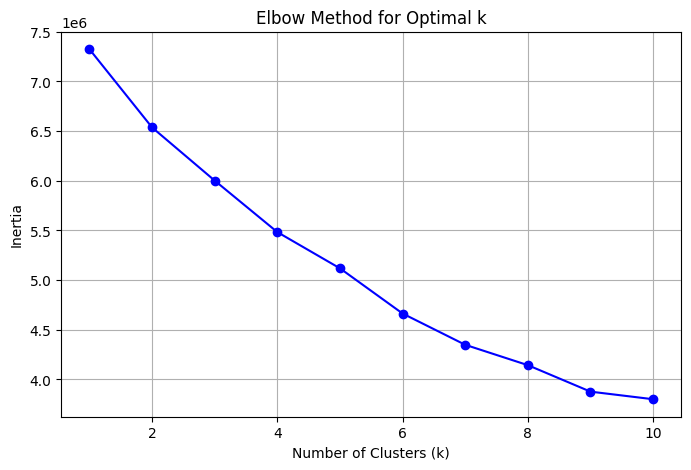

In [14]:
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled) 
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()


In [16]:
# Apply K-means clustering with k = 5
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)

# Convert X_scaled back to a DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Add the 'Cluster' column
X_scaled_df['Cluster'] = kmeans.fit_predict(X_scaled)



c:\Users\jayjo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [17]:
# Key statistics of the K-means clustering

# 1. Cluster Centers
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)

# 2. Inertia
inertia_value = kmeans.inertia_

# 3. Labels (already assigned as 'Cluster' in the DataFrame)
labels = kmeans.labels_

# 4. Cluster Sizes
cluster_sizes = pd.Series(labels).value_counts().sort_index()

# Display the statistics
cluster_stats = {
    "Cluster Centers": cluster_centers,
    "Inertia": inertia_value,
    "Cluster Sizes": cluster_sizes
}

cluster_stats


{'Cluster Centers':    Hospital_code  Hospital_type_code  City_Code_Hospital  \
 0      -0.250152            0.347194           -1.215691   
 1      -0.004198            1.141492            1.544096   
 2      -0.506038            0.494703           -0.251124   
 3       0.188519           -0.675319            0.635495   
 4       0.355298           -0.431847           -0.238504   
 
    Available Extra Rooms in Hospital  Ward_Type  Bed Grade  City_Code_Patient  \
 0                          -0.005349  -0.019074   0.106340          -0.054312   
 1                          -0.227178   0.619485  -0.063324           0.206337   
 2                          -0.000698   0.105044   0.043678           0.142211   
 3                           0.024457  -0.141010   0.090774          -0.310276   
 4                           0.073554  -0.186884  -0.154417           0.126457   
 
    Type of Admission  Severity of Illness  Visitors with Patient  ...  \
 0          -0.065633            -0.070897   

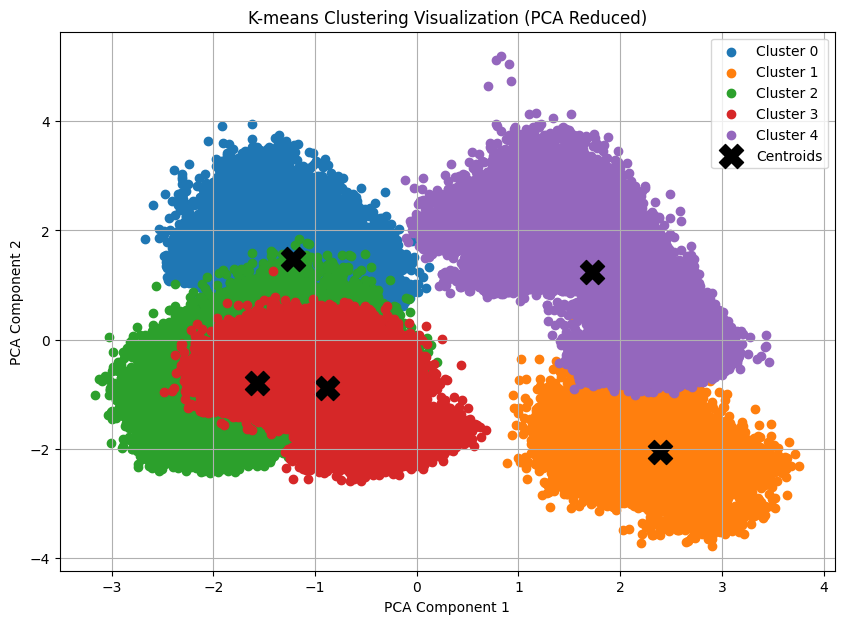

In [20]:
# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)

# Add PCA components to the DataFrame for plotting
X_scaled_df['PCA1'] = pca_components[:, 0]
X_scaled_df['PCA2'] = pca_components[:, 1]

# Plotting the clusters
plt.figure(figsize=(10, 7))
for cluster in range(optimal_k):
    plt.scatter(
        X_scaled_df[X_scaled_df['Cluster'] == cluster]['PCA1'],
        X_scaled_df[X_scaled_df['Cluster'] == cluster]['PCA2'],
        label=f'Cluster {cluster}'
    )

# Marking the cluster centers
centers_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], s=300, c='black', marker='X', label='Centroids')

plt.title('K-means Clustering Visualization (PCA Reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.show()


Random Forest

In [24]:
# Initialize and train the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

accuracy, report

(0.3837614621278734,
 '              precision    recall  f1-score   support\n\n           1       0.28      0.19      0.23      4689\n           2       0.39      0.45      0.42     15561\n           3       0.42      0.53      0.47     17603\n           4       0.33      0.27      0.29     10981\n           5       0.10      0.03      0.04      2357\n           6       0.40      0.46      0.43      7128\n           7       0.10      0.02      0.03       554\n           8       0.29      0.11      0.16      2031\n           9       0.38      0.18      0.24       941\n          10       0.28      0.07      0.11       552\n          11       0.53      0.44      0.48      1291\n\n    accuracy                           0.38     63688\n   macro avg       0.32      0.25      0.26     63688\nweighted avg       0.36      0.38      0.37     63688\n')